In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [176]:
# read data from csv file
df= pd.read_csv('../data/LasVegasTripAdvisorReviews-Dataset.csv', sep= ';')
print(df.shape)
df.head(4)

(504, 20)


,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,9,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,3,January,Friday
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,2,February,Saturday
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,Europe,6,February,Friday


In [177]:
df.describe()

,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Nr. rooms,Member years
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,48.130952,16.023810,31.751984,4.123016,2196.380952,0.767857
std,74.996426,23.957953,48.520783,1.007302,1285.476807,80.692897
min,1.000000,0.000000,0.000000,1.000000,188.000000,-1806.000000
25%,12.000000,5.000000,8.000000,4.000000,826.000000,2.000000
50%,23.500000,9.000000,16.000000,4.000000,2700.000000,4.000000
75%,54.250000,18.000000,35.000000,5.000000,3025.000000,6.000000
max,775.000000,263.000000,365.000000,5.000000,4027.000000,13.000000


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   User country       504 non-null    object
 1   Nr. reviews        504 non-null    int64 
 2   Nr. hotel reviews  504 non-null    int64 
 3   Helpful votes      504 non-null    int64 
 4   Score              504 non-null    int64 
 5   Period of stay     504 non-null    object
 6   Traveler type      504 non-null    object
 7   Pool               504 non-null    object
 8   Gym                504 non-null    object
 9   Tennis court       504 non-null    object
 10  Spa                504 non-null    object
 11  Casino             504 non-null    object
 12  Free internet      504 non-null    object
 13  Hotel name         504 non-null    object
 14  Hotel stars        504 non-null    object
 15  Nr. rooms          504 non-null    int64 
 16  User continent     504 non-null    object
 1

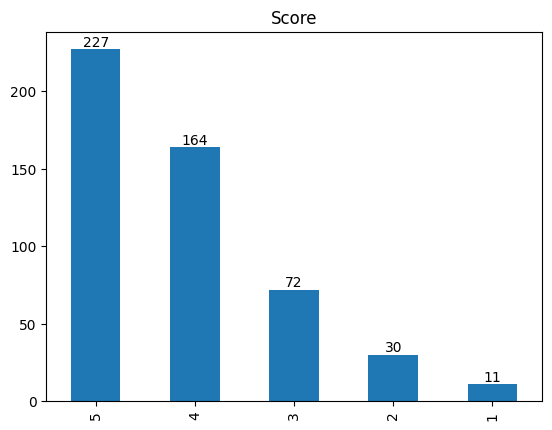

In [179]:
ax= df['Score'].value_counts().plot.bar(title='Score')
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
# có 5 mức điểm đánh giá của khách sạn

#### Data Cleaning

In [180]:
# data missing
miss_val = pd.DataFrame(df.isnull().sum(), columns=['No. of missing values'])
miss_val['% missing_values'] = (miss_val/len(df)).round(2)*100
miss_val
# không có missing value

,No. of missing values,% missing_values
User country,0,0.0
Nr. reviews,0,0.0
Nr. hotel reviews,0,0.0
Helpful votes,0,0.0
Score,0,0.0
Period of stay,0,0.0
Traveler type,0,0.0
Pool,0,0.0
Gym,0,0.0
Tennis court,0,0.0


##### Biến phân loại

In [181]:
cat_cols= df.drop('Score', axis= 1).select_dtypes(object).columns.tolist()
print('Có', len(cat_cols), ' biến phân loại , gồm có:', "\n", cat_cols, '\n')
for i in cat_cols:
    unique_no = df[i].nunique()
    unique_name = df[i].unique().tolist()
    print(i, 'có ', unique_no, 'có giá trị :')
    print(unique_name, "\n")
# Score là biến mục tiêu

Có 14  biến phân loại , gồm có: 
 ['User country', 'Period of stay', 'Traveler type', 'Pool', 'Gym', 'Tennis court', 'Spa', 'Casino', 'Free internet', 'Hotel name', 'Hotel stars', 'User continent', 'Review month', 'Review weekday'] 

User country có  48 có giá trị :
['USA', 'UK', 'Canada', 'India', 'Australia', 'New Zeland', 'Ireland', 'Egypt', 'Finland', 'Kenya', 'Jordan', 'Netherlands', 'Syria', 'Scotland', 'South Africa', 'Swiss', 'United Arab Emirates', 'Hungary', 'China', 'Greece', 'Mexico', 'Croatia', 'Germany', 'Malaysia', 'Thailand', 'Phillippines', 'Israel', 'India ', 'Belgium', 'Puerto Rico', 'Switzerland', 'Norway', 'France', 'Spain', 'Singapore', 'Brazil', 'Costa Rica', 'Iran', 'Saudi Arabia', 'Honduras', 'Denmark', 'Taiwan', 'Hawaii', 'Kuwait', 'Czech Republic', 'Japan', 'Korea', 'Italy'] 

Period of stay có  4 có giá trị :
['Dec-Feb', 'Mar-May', 'Jun-Aug', 'Sep-Nov'] 

Traveler type có  5 có giá trị :
['Friends', 'Business', 'Families', 'Solo', 'Couples'] 

Pool có  2 có 

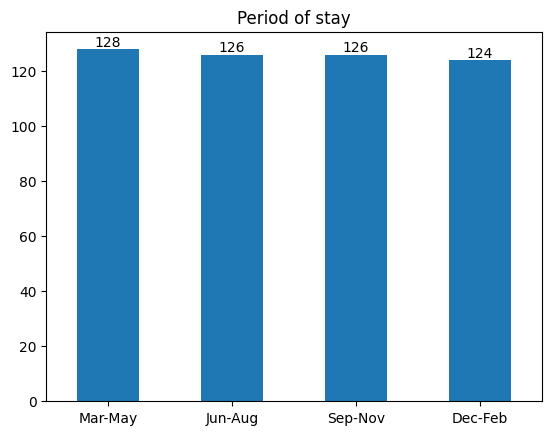

In [182]:
ax= df['Period of stay'].value_counts().plot.bar(title='Period of stay', rot= 0)
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
# số lượng đánh giá theo thời gian ở

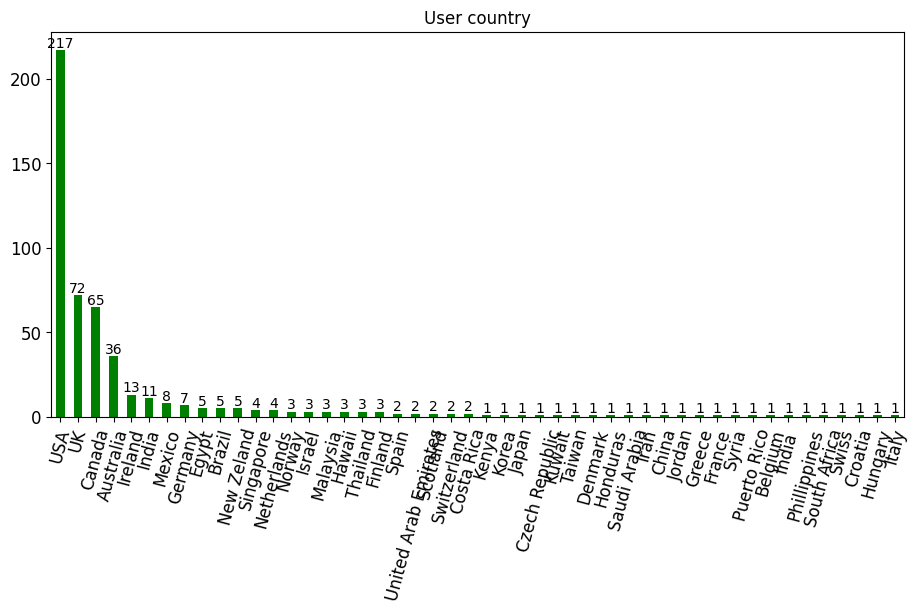

In [183]:
ax= df['User country'].value_counts().plot.bar(title='User country', figsize=(11, 5), fontsize=12, color='green', rot= 75)
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
# số lượng người USA là nhiều nhất, sau đó là UK, Canada, còn lại tương đối ít

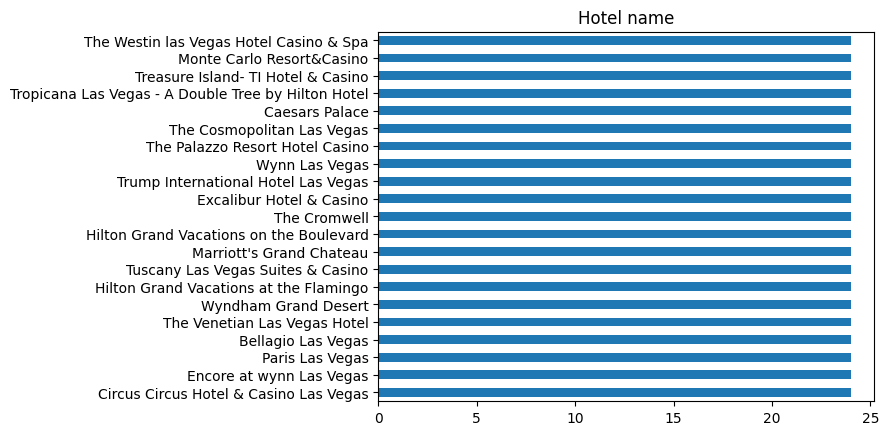

In [184]:
ax= df['Hotel name'].value_counts().plot.barh(title='Hotel name')
# số lượng đánh giá của mỗi khách sạn bằng nhau

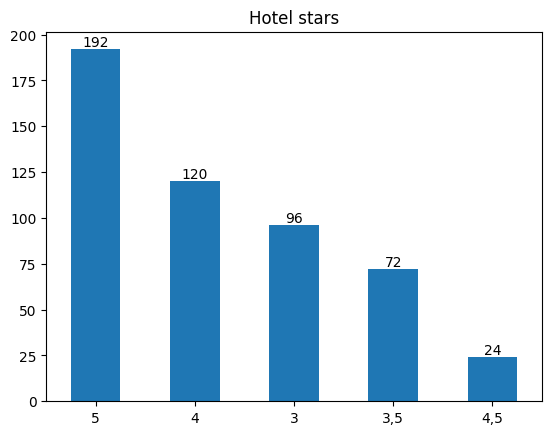

In [185]:
ax= df['Hotel stars'].value_counts().plot.bar(title='Hotel stars', rot= 0)
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
# có 5 loại khách sạn

In [186]:
# tính thử chi-quare cho 2 biến phân loại
cont_table = pd.crosstab(df['Free internet'], df['Hotel stars'])
chi2, p, dof, expected = chi2_contingency(cont_table)
print("Chi-square statistic:", chi2)
print("P-value:", p)

Chi-square statistic: 80.64
P-value: 1.274696526892647e-16


##### Biến liên tục

In [187]:
# Do Score là biến mục tiêu nên không tính vào biến liên tục
num_cols = df.drop('Score', axis= 1).select_dtypes(include=np.number).columns.tolist()
print('Có :', len(num_cols), 'biến liên tục,gồm có:')
print(num_cols, "\n")

Có : 5 biến liên tục,gồm có:
['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Nr. rooms', 'Member years'] 



In [188]:
df[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Nr. rooms', 'Member years']].describe()
# 

,Nr. reviews,Nr. hotel reviews,Helpful votes,Nr. rooms,Member years
count,504.000000,504.000000,504.000000,504.000000,504.000000
mean,48.130952,16.023810,31.751984,2196.380952,0.767857
std,74.996426,23.957953,48.520783,1285.476807,80.692897
min,1.000000,0.000000,0.000000,188.000000,-1806.000000
25%,12.000000,5.000000,8.000000,826.000000,2.000000
50%,23.500000,9.000000,16.000000,2700.000000,4.000000
75%,54.250000,18.000000,35.000000,3025.000000,6.000000
max,775.000000,263.000000,365.000000,4027.000000,13.000000


In [189]:
df[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Nr. rooms', 'Member years']].head()
# 	Nr. hotel reviews: số lượng đánh giá về khách sạn
# 	Nr. reviews: số lượng đánh giá của khách hàng
#   Nr. rooms: số lượng phòng
#   Member years: số năm người dùng là thành viên của TripAdvisor

,Nr. reviews,Nr. hotel reviews,Helpful votes,Nr. rooms,Member years
0,11,4,13,3773,9
1,119,21,75,3773,3
2,36,9,25,3773,2
3,14,7,14,3773,6
4,5,5,2,3773,7


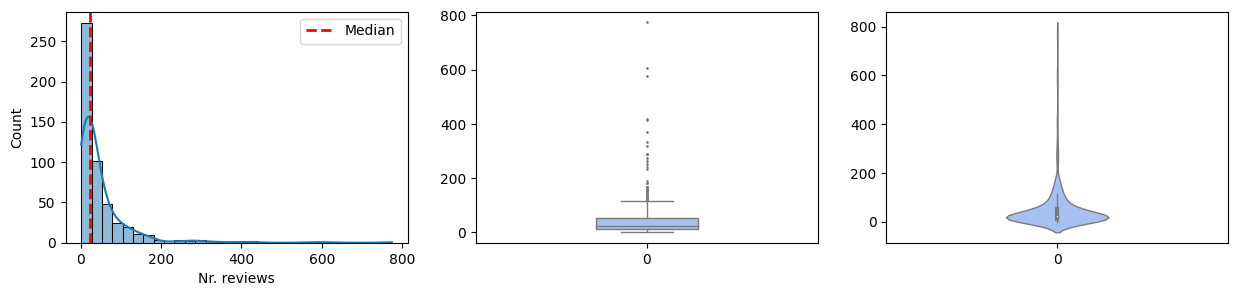

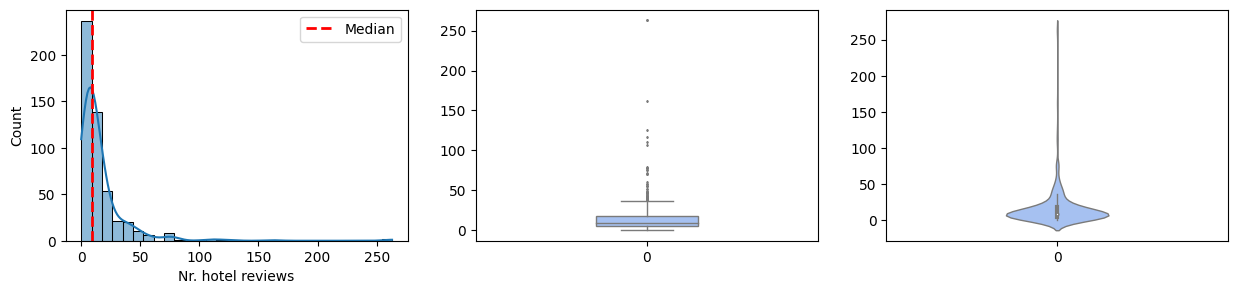

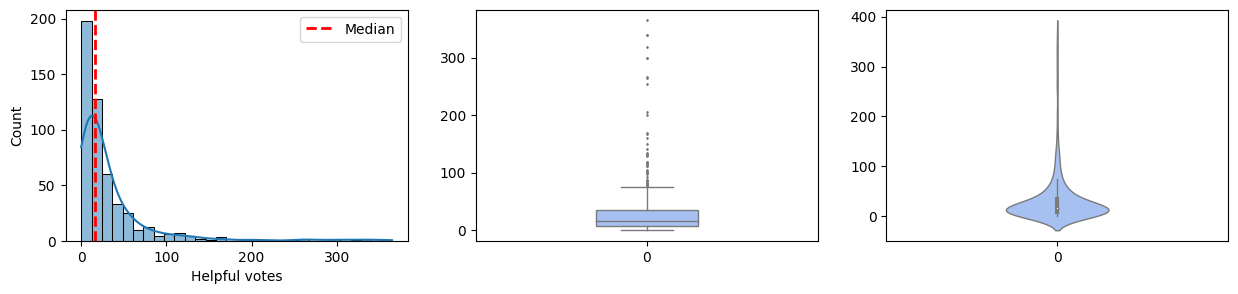

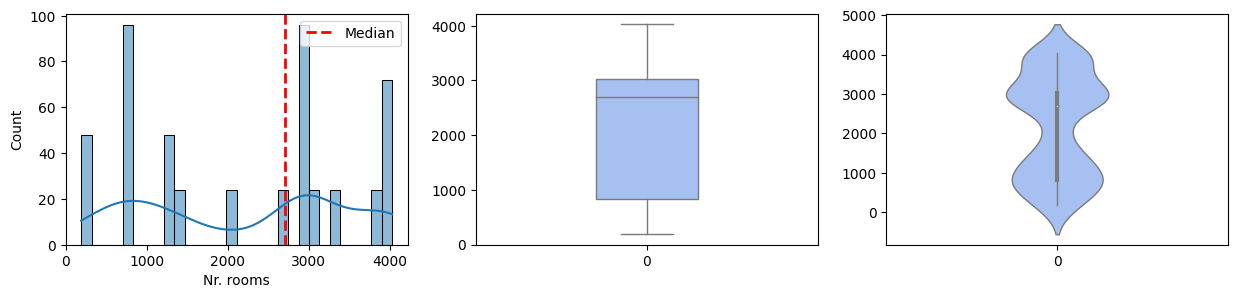

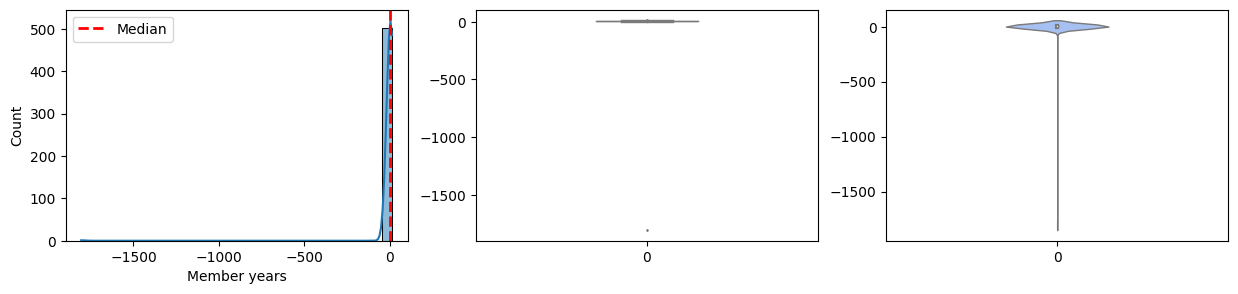

In [190]:
for i in num_cols:      
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    sns.histplot(df[i], bins= 30 , kde=True, ax=axs[0])
    sns.boxplot(df[i], ax = axs[1], color='#99befd', fliersize=1, linewidth=1, width=0.3)
    sns.violinplot(df[i], ax = axs[2], color='#99befd', fliersize=1, linewidth=1, width=0.3)
    
    axs[0].axvline(df[i].median(), color='r', linewidth=2, linestyle='--', label='Median')
    axs[0].legend()

- Các biến 'Nr. reviews', 'Nr. hotel reviews', 'Helpful votes' là positive skew (nhiều outliers).
- Biến 'Member years' có giá trị không hợp lệ (< 0)

In [191]:
# xử lý với biến Member years
df[df['Member years']<0]

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
75,USA,17,9,16,5,Dec-Feb,Solo,YES,YES,YES,YES,YES,YES,Treasure Island- TI Hotel & Casino,4,2884,North America,-1806,February,Monday


In [192]:
# fill biến không hợp lệ bằng median
df.loc[df[df['Member years']<0].index, 'Member years']= np.NaN
df['Member years'].fillna(df['Member years'].median(), inplace=True)

<Axes: >

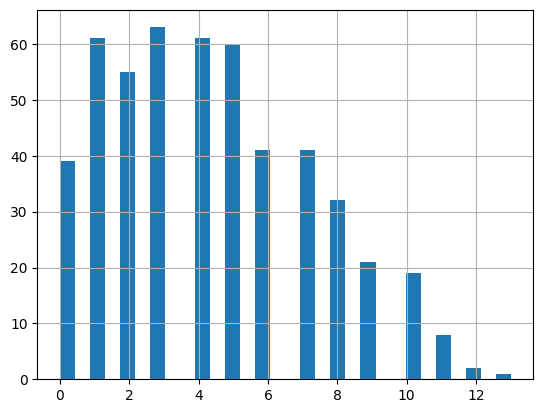

In [193]:
# sau khi fill
df['Member years'].hist(bins= 30)

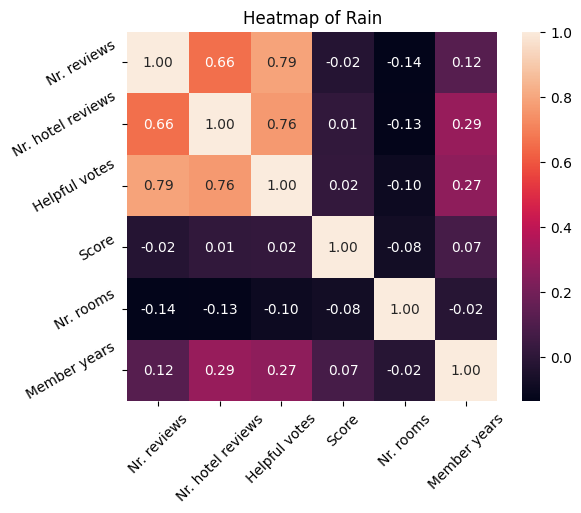

In [194]:
# ma trận tương quan
correlation = df.corr()
plt.title('Heatmap of Rain')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

- Helpful votes có tương quan với Nr. reviews cao: 0.79 chứng tỏ số lượng người reviews càng lớn thì số lượng vote hữu ích cao
- Helpful votes có tương quan với Nr. hotel reviews: 0.76 chứng tỏ số lượng reviews về khách sạn càng lớn thì số lượng vote hữu ích cao

#### Data Transform

In [195]:
df= pd.get_dummies(df, columns= cat_cols, drop_first= True)

In [196]:
print(df.shape)
df.head()

(504, 112)


,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Nr. rooms,Member years,User country_Belgium,User country_Brazil,User country_Canada,User country_China,...,Review month_May,Review month_November,Review month_October,Review month_September,Review weekday_Monday,Review weekday_Saturday,Review weekday_Sunday,Review weekday_Thursday,Review weekday_Tuesday,Review weekday_Wednesday
0,11,4,13,5,3773,9.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,119,21,75,3,3773,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,36,9,25,5,3773,2.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,14,7,14,4,3773,6.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,5,2,4,3773,7.0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


##### Data transform to visualization

In [210]:
tsne = manifold.TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(df.copy().drop('Score', axis= 1))

tsne_df = pd.DataFrame(
        np.column_stack((transformed_data, df['Score'])), 
        columns=["x", "y", "targets"])
tsne_df.loc[:, "targets"] = tsne_df.targets.astype(int)
grid = sns.FacetGrid(tsne_df, hue="targets")
grid.map(plt.scatter, "x", "y").add_legend()

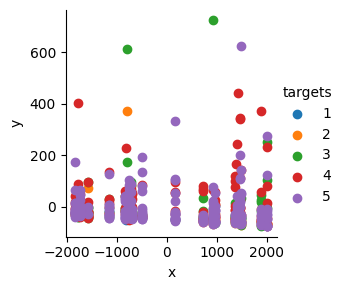

In [204]:
pca = PCA(n_components=2, random_state=42)
transformed_data = pca.fit_transform(df.copy().drop('Score', axis= 1))

pca_df = pd.DataFrame(
        np.column_stack((transformed_data, df['Score'])), 
        columns=["x", "y", "targets"])
pca_df.loc[:, "targets"] = pca_df.targets.astype(int)
grid = sns.FacetGrid(pca_df, hue="targets")
grid.map(plt.scatter, "x", "y").add_legend()

##### Normalization

In [207]:
# vì dữ liệu liên tục có phân phối positive skew nên sẽ dùng log để chuẩn hóa
print(num_cols)

['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Nr. rooms', 'Member years']


In [223]:
log_data = df.copy()
log_data[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Member years']] = np.log1p(log_data[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Member years']])

In [224]:
df['Member years'].value_counts()

3.0     63
4.0     61
1.0     61
5.0     60
2.0     55
6.0     41
7.0     41
0.0     39
8.0     32
9.0     21
10.0    19
11.0     8
12.0     2
13.0     1
Name: Member years, dtype: int64

array([[<Axes: title={'center': 'Nr. reviews'}>,
        <Axes: title={'center': 'Nr. hotel reviews'}>],
       [<Axes: title={'center': 'Helpful votes'}>,
        <Axes: title={'center': 'Member years'}>]], dtype=object)

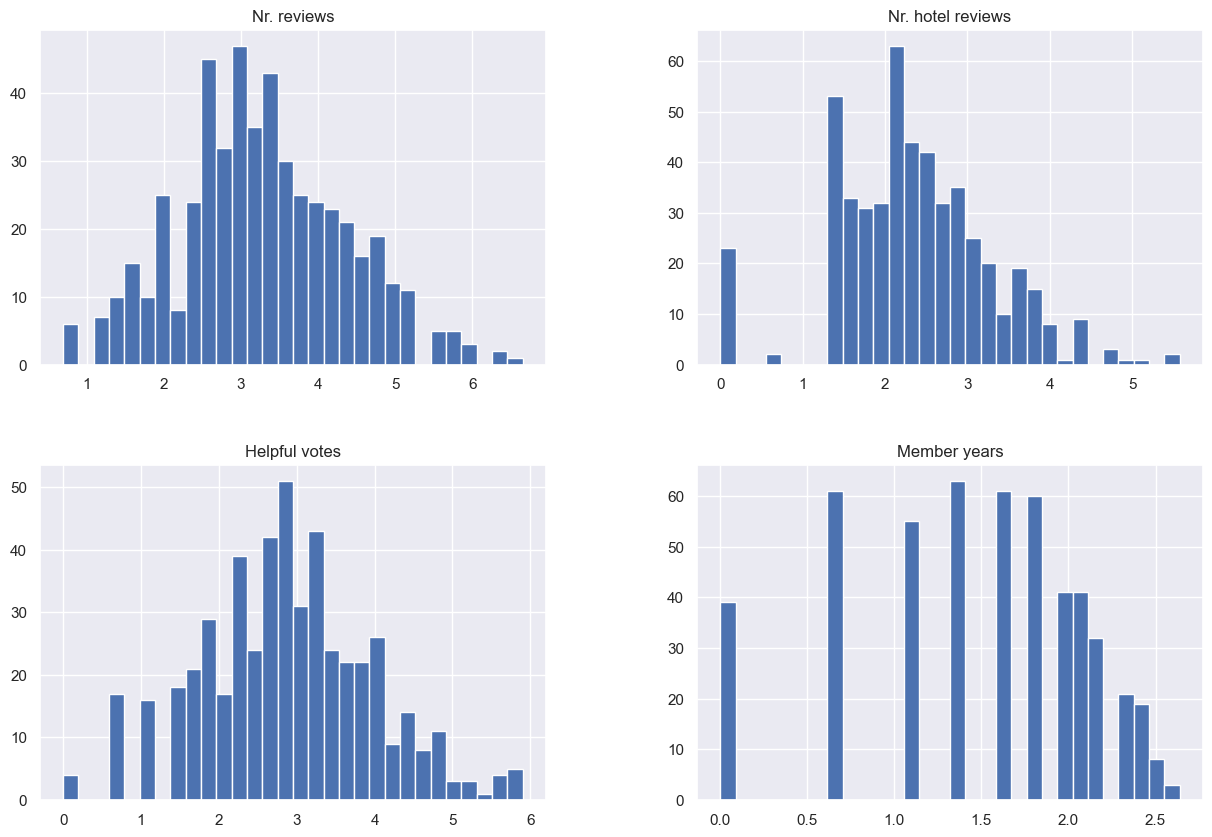

In [225]:
log_data[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Member years']].hist(bins= 30, figsize=(15, 10))

<Axes: >

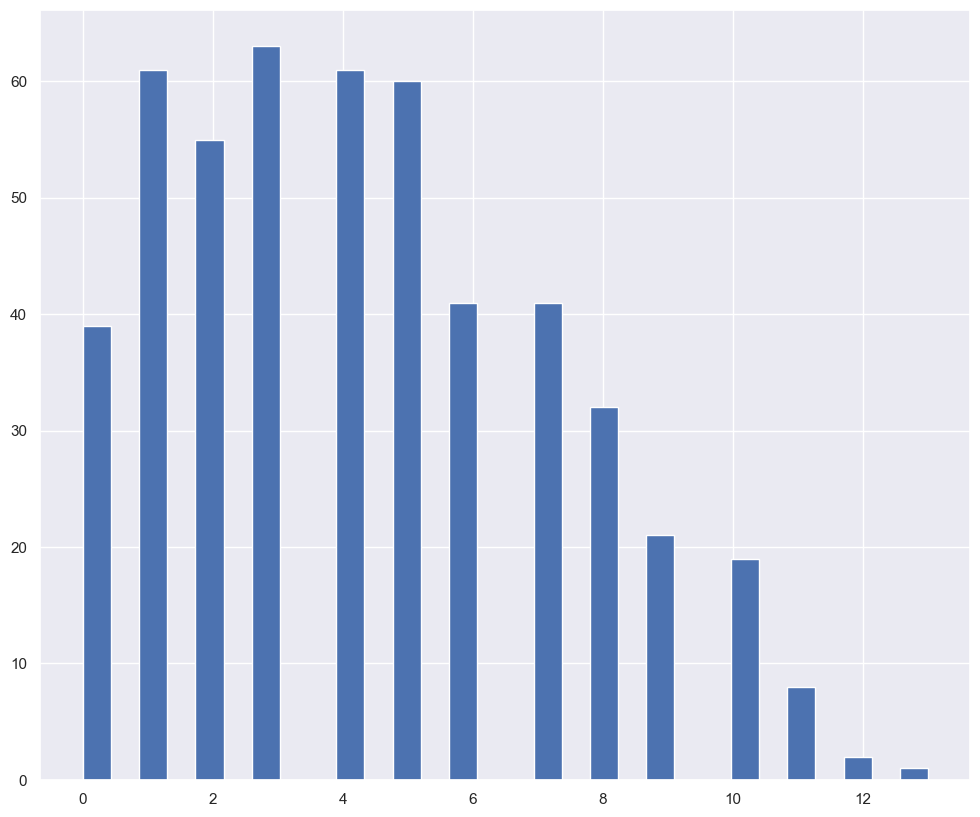

In [222]:
log_data['Member years'].hist(bins= 30, figsize=(12, 10))

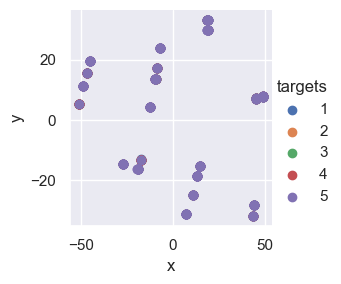

In [213]:
# giảm chiều 
tsne = manifold.TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(log_data.copy().drop('Score', axis= 1))

tsne_log_data = pd.DataFrame(
        np.column_stack((transformed_data, log_data['Score'])), 
        columns=["x", "y", "targets"])
tsne_log_data.loc[:, "targets"] = tsne_log_data.targets.astype(int)
sns.set(rc={'figure.figsize':(15, 9)})
grid = sns.FacetGrid(tsne_log_data, hue="targets")
grid.map(plt.scatter, "x", "y").add_legend()

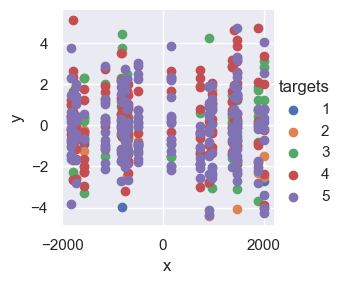

In [214]:
pca = PCA(n_components=2, random_state=42)
transformed_data = pca.fit_transform(log_data.copy().drop('Score', axis= 1))

pca_log_data = pd.DataFrame(
        np.column_stack((transformed_data, log_data['Score'])), 
        columns=["x", "y", "targets"])
pca_log_data.loc[:, "targets"] = pca_log_data.targets.astype(int)
grid = sns.FacetGrid(pca_log_data, hue="targets")
grid.map(plt.scatter, "x", "y").add_legend()

In [ ]:
log_data.to_csv('../data/new_data.csv', index= False)